In [12]:
# Cell 0 - CONFIG
CANDIDATE_NAME = "TUSHAR_SINGH"
ROOT_DIR = f"./ds_{CANDIDATE_NAME}"     # local folder
CSV_DIR = f"{ROOT_DIR}/csv_files"
OUTPUTS_DIR = f"{ROOT_DIR}/outputs"

# 👇 Update these two lines
HISTORICAL_FILE_PATH = "./historical_data.csv"
FEAR_GREED_PATH = "./fear_greed_index.csv"


In [13]:
 pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [14]:
!pip install -U scikit-learn


Defaulting to user installation because normal site-packages is not writeable


In [15]:
# Cell 1 - Installand imports
!pip install --quiet gdown missingno pandasql

import os, re, math, zipfile, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from datetime import datetime, timezone, timedelta
from dateutil import parser
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')
logger = logging.getLogger("ds_assignment")

# plotting defaults
plt.rcParams['figure.figsize'] = (10,5)
sns.set(style="whitegrid")


In [16]:
# Cell 2 - Robust CSV loader for large files & unknown encodings
def read_csv_flex(path, nrows=None, chunksize=2_000_00, sample=False):
    """
    Tries to load a CSV flexibly:
    - if file small -> full pd.read_csv
    - if large -> chunked read and concat (with nrows or sample options)
    - tries common encodings if UnicodeDecodeError
    """
    logger.info("Reading CSV: %s", path)
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    filesize_mb = os.path.getsize(path) / (1024*1024)
    logger.info("File size %.2f MB", filesize_mb)
    try_encs = ['utf-8','utf-8-sig','latin1','ISO-8859-1']
    for enc in try_encs:
        try:
            if filesize_mb < 40 and nrows is None:
                # small file - read directly
                df = pd.read_csv(path, encoding=enc)
                logger.info("Read full CSV with encoding %s", enc)
                if sample:
                    return df.sample(min(len(df), 5000), random_state=1)
                return df
            else:
                # large file -> read in chunks
                pieces = []
                read = 0
                for chunk in pd.read_csv(path, encoding=enc, chunksize=chunksize, iterator=True):
                    pieces.append(chunk)
                    read += len(chunk)
                    logger.info("Read rows: %d", read)
                    if nrows and read >= nrows:
                        break
                    if sample and read >= 50000:
                        break
                df = pd.concat(pieces, ignore_index=True)
                logger.info("Concatenated %d rows from chunks (encoding %s)", len(df), enc)
                if nrows:
                    return df.head(nrows)
                if sample:
                    return df.sample(min(len(df), 5000), random_state=1)
                return df
        except UnicodeDecodeError:
            logger.warning("Encoding %s failed, trying next", enc)
            continue
        except Exception as e:
            logger.warning("Reading failed with encoding %s: %s", enc, e)
            continue
    raise ValueError("All attempts to read CSV failed for: " + path)


In [17]:
# Cell 3 - Load files
try:
    trades_raw = read_csv_flex(HISTORICAL_FILE_PATH, sample=False)
    logger.info("Trades loaded shape: %s", trades_raw.shape)
except Exception as e:
    logger.exception("Failed to load historical trades file: %s", e)
    raise

try:
    feargreed = read_csv_flex(FEAR_GREED_PATH, sample=False)
    logger.info("Fear/Greed loaded shape: %s", feargreed.shape)
except Exception as e:
    logger.exception("Failed to load fear/greed file: %s", e)
    raise

# quick peek
display(trades_raw.head(6))
display(feargreed.head(6))


2025-10-23 14:23:02,846 INFO Reading CSV: ./historical_data.csv
2025-10-23 14:23:02,847 INFO File size 45.32 MB
2025-10-23 14:23:03,332 INFO Read rows: 200000
2025-10-23 14:23:03,364 INFO Read rows: 211224
2025-10-23 14:23:03,374 INFO Concatenated 211224 rows from chunks (encoding utf-8)
2025-10-23 14:23:03,378 INFO Trades loaded shape: (211224, 16)
2025-10-23 14:23:03,379 INFO Reading CSV: ./fear_greed_index.csv
2025-10-23 14:23:03,380 INFO File size 0.09 MB
2025-10-23 14:23:03,407 INFO Read full CSV with encoding utf-8
2025-10-23 14:23:03,408 INFO Fear/Greed loaded shape: (2644, 4)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12
5,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9900,1.41,11.27,BUY,02-12-2024 22:50,1298.215466,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.000493,7.330000e+14,1.730000e+12


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05
5,1517895000,8,Extreme Fear,2018-02-06


In [18]:
# Cell 4 - Normalize column names for both tables
def normalize_cols(df):
    df = df.copy()
    col_map = {}
    for c in df.columns:
        cs = c.strip()
        cs = re.sub(r'\s+', '_', cs)            # spaces -> underscores
        cs = re.sub(r'[^0-9A-Za-z_]', '', cs)   # remove special chars
        cs = cs.strip().lower()
        col_map[c] = cs
    df.rename(columns=col_map, inplace=True)
    return df

trades = normalize_cols(trades_raw)
fg = normalize_cols(feargreed)

logger.info("Trade columns: %s", trades.columns.tolist())
logger.info("FearGreed columns: %s", fg.columns.tolist())


2025-10-23 14:23:03,614 INFO Trade columns: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']
2025-10-23 14:23:03,615 INFO FearGreed columns: ['timestamp', 'value', 'classification', 'date']


In [19]:
# Cell 5 - Map likely names to expected columns
# Expected trade fields from sample: account, coin (maybe "Coin"), execution price, size tokens, size usd, side, timestamp ist, start position, direction, closed pnl
col_candidates = { 'account': None, 'coin': None, 'execution_price': None, 'size_tokens': None,
                   'size_usd': None, 'side': None, 'timestamp_ist': None, 'start_position': None,
                   'direction': None, 'closed_pnl': None, 'order_id': None, 'transaction_hash': None,
                   'fee': None, 'trade_id': None}

for std in list(col_candidates.keys()):
    for c in trades.columns:
        if std in c or std.replace('_','') in c:
            col_candidates[std] = c
            break

# fallback searches by partial matches from sample column names
fuzzy_map = {
    'account': ['account'],
    'coin': ['coin','symbol'],
    'execution_price': ['executionprice','execution_price','price'],
    'size_tokens': ['sizetokens','size_tokens','size_tokens','size'],
    'size_usd': ['sizeusd','size_usd','size_usd','sizeusd'],
    'side': ['side','direction'],
    'timestamp_ist': ['timestampist','timestamp_ist','timestamp','time'],
    'start_position': ['startposition','start_position','startpos'],
    'closed_pnl': ['closedpnl','closed_pnl','pnl','profit','closedpnl'],
    'order_id': ['orderid','order_id'],
    'transaction_hash': ['transactionhash','transaction_hash','tx'],
    'fee': ['fee'],
    'trade_id': ['tradeid','trade_id']
}

for std, options in fuzzy_map.items():
    if col_candidates[std] is None:
        for opt in options:
            found = [c for c in trades.columns if opt in c]
            if found:
                col_candidates[std] = found[0]
                break

logger.info("Column mapping (detected):")
for k,v in col_candidates.items():
    logger.info("  %s -> %s", k, v)


2025-10-23 14:23:03,626 INFO Column mapping (detected):
2025-10-23 14:23:03,627 INFO   account -> account
2025-10-23 14:23:03,628 INFO   coin -> coin
2025-10-23 14:23:03,628 INFO   execution_price -> execution_price
2025-10-23 14:23:03,629 INFO   size_tokens -> size_tokens
2025-10-23 14:23:03,629 INFO   size_usd -> size_usd
2025-10-23 14:23:03,629 INFO   side -> side
2025-10-23 14:23:03,630 INFO   timestamp_ist -> timestamp_ist
2025-10-23 14:23:03,630 INFO   start_position -> start_position
2025-10-23 14:23:03,631 INFO   direction -> direction
2025-10-23 14:23:03,631 INFO   closed_pnl -> closed_pnl
2025-10-23 14:23:03,632 INFO   order_id -> order_id
2025-10-23 14:23:03,632 INFO   transaction_hash -> transaction_hash
2025-10-23 14:23:03,632 INFO   fee -> fee
2025-10-23 14:23:03,633 INFO   trade_id -> trade_id


In [20]:
# Cell 6 - helpers: numeric cleaning, coin cleaning, timestamp parsing (IST -> UTC)
def to_numeric_safe(s):
    """Convert values to float safely (remove commas, parentheses, $ etc.)"""
    if pd.isna(s):
        return np.nan
    if isinstance(s, (int, float, np.integer, np.floating)):
        return float(s)
    try:
        st = str(s).strip()
        # remove commas and common currency symbols
        st = re.sub(r'[,\$\u20B9]', '', st)
        # fix weird unicode minus
        st = st.replace('\u2212','-')
        # empty
        if st=='':
            return np.nan
        return float(st)
    except Exception:
        return np.nan

def clean_coin(c):
    if pd.isna(c):
        return c
    s = str(c).strip()
    # sample had '@107' as coin - keep a cleaned version
    s = s.replace('@','').strip()
    # uppercase common token names if letters present
    if any(ch.isalpha() for ch in s):
        return s.upper()
    return s

IST_OFFSET = timedelta(hours=5, minutes=30)
def parse_timestamp_ist(val):
    if pd.isna(val):
        return pd.NaT
    if isinstance(val, (pd.Timestamp, datetime)):
        return pd.to_datetime(val).tz_localize(timezone.utc) # safe fallback
    s = str(val).strip()
    # use dateutil.parser with dayfirst heuristics fallback
    try:
        dt = parser.parse(s, dayfirst=False)
    except Exception:
        try:
            dt = parser.parse(s, dayfirst=True)
        except Exception:
            return pd.NaT
    # assume naive dt is IST (no tzinfo)
    if dt.tzinfo is None:
        # attach IST tz offset by converting to UTC
        # represent dt as timezone-aware in UTC
        dt_utc = (dt - IST_OFFSET).replace(tzinfo=timezone.utc)
        return pd.to_datetime(dt_utc)
    else:
        # convert to UTC
        return pd.to_datetime(dt).tz_convert(timezone.utc)

# quick test (uncomment to test)
# print(parse_timestamp_ist("2/12/2024 22:50"))


In [21]:
# Cell 7 - Apply cleaning using detected columns
# Use mapping from col_candidates
def get_col(k):
    c = col_candidates.get(k)
    return c if (c in trades.columns) else None

df = trades.copy()

# apply coin cleaning
coin_col = get_col('coin')
if coin_col:
    df['coin_clean'] = df[coin_col].apply(clean_coin)
else:
    df['coin_clean'] = np.nan

# numeric fields: execution price, size tokens, size usd, closed pnl, fee, start position
for field in ['execution_price','size_tokens','size_usd','closed_pnl','fee','start_position']:
    c = get_col(field)
    if c:
        df[field] = df[c].apply(to_numeric_safe)
    else:
        df[field] = np.nan

# side (BUY/SELL) normalize
side_col = get_col('side')
if side_col:
    df['side'] = df[side_col].astype(str).str.strip().str.upper()
else:
    df['side'] = df.get('direction',np.nan).astype(str).str.strip().str.upper()

# account
acc_c = get_col('account')
df['account'] = df[acc_c].astype(str).str.strip() if acc_c else df.get('account', np.nan)

# transaction/order/trade ids - convert to string, preserve leading zeros
for idcol in ['transaction_hash','order_id','trade_id']:
    c = get_col(idcol)
    if c:
        df[idcol] = df[c].apply(lambda x: str(x).strip() if pd.notna(x) else np.nan)
    else:
        df[idcol] = np.nan

# parse timestamp IST into UTC datetime and build trade_date (date only in UTC)
ts_col = get_col('timestamp_ist')
if ts_col:
    df['trade_time_utc'] = df[ts_col].apply(parse_timestamp_ist)
else:
    # try generic columns named 'timestamp' or 'time'
    fallback = [c for c in df.columns if 'time' in c and c not in ['trade_time_utc']]
    if fallback:
        df['trade_time_utc'] = df[fallback[0]].apply(parse_timestamp_ist)
    else:
        df['trade_time_utc'] = pd.NaT

df['trade_date_utc'] = pd.to_datetime(df['trade_time_utc']).dt.date

# Simple checks
logger.info("After cleaning: rows=%d, trade_time_nulls=%d", len(df), df['trade_time_utc'].isna().sum())
display(df[['account','coin_clean','execution_price','size_tokens','size_usd','side','trade_time_utc','trade_date_utc','closed_pnl']].head(8))


2025-10-23 14:23:20,745 INFO After cleaning: rows=211224, trade_time_nulls=0


,account,coin_clean,execution_price,size_tokens,size_usd,side,trade_time_utc,trade_date_utc,closed_pnl
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,107,7.9769,986.87,7872.16,BUY,2024-02-12 17:20:00+00:00,2024-02-12,0.0
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,107,7.9800,16.00,127.68,BUY,2024-02-12 17:20:00+00:00,2024-02-12,0.0
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,107,7.9855,144.09,1150.63,BUY,2024-02-12 17:20:00+00:00,2024-02-12,0.0
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,107,7.9874,142.98,1142.04,BUY,2024-02-12 17:20:00+00:00,2024-02-12,0.0
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,107,7.9894,8.73,69.75,BUY,2024-02-12 17:20:00+00:00,2024-02-12,0.0
5,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,107,7.9900,1.41,11.27,BUY,2024-02-12 17:20:00+00:00,2024-02-12,0.0
6,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,107,7.9934,144.09,1151.77,BUY,2024-02-12 17:20:00+00:00,2024-02-12,0.0
7,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,107,8.0000,34.00,272.00,BUY,2024-02-12 17:20:00+00:00,2024-02-12,0.0


In [22]:
# Cell 8 - Prepare fear/greed index
fg_cols = fg.columns.tolist()
logger.info("Fear/Greed raw columns: %s", fg_cols)

# identify date and classification columns heuristically
date_col = None
class_col = None
for c in fg.columns:
    if 'date' in c:
        date_col = c
    if 'class' in c or 'classification' in c or 'fear' in c.lower() or 'greed' in c.lower():
        class_col = c

# fallback if none found
if date_col is None:
    for c in fg.columns:
        # try first column if convertible to date
        try:
            pd.to_datetime(fg[c], errors='coerce')
            date_col = c
            break
        except:
            continue

if class_col is None:
    # try any column with few unique values (like 'Fear'/'Greed')
    for c in fg.columns:
        vals = fg[c].dropna().unique()
        if len(vals) <= 4 and any('fear' in str(v).lower() or 'greed' in str(v).lower() for v in vals.astype(str)):
            class_col = c
            break

if date_col is None or class_col is None:
    logger.warning("Could not confidently detect date or classification columns in fear/greed. Columns: %s", fg.columns.tolist())

# standardize
fg['fg_date'] = pd.to_datetime(fg[date_col], errors='coerce').dt.date
fg['classification'] = fg[class_col].astype(str).str.strip().str.title()
fg_simple = fg[['fg_date','classification']].dropna(subset=['fg_date']).drop_duplicates()
logger.info("Fear/Greed cleaned rows: %d", len(fg_simple))
display(fg_simple.head(8))


2025-10-23 14:23:20,838 INFO Fear/Greed raw columns: ['timestamp', 'value', 'classification', 'date']
2025-10-23 14:23:20,976 INFO Fear/Greed cleaned rows: 2644


,fg_date,classification
0,2018-02-01,Fear
1,2018-02-02,Extreme Fear
2,2018-02-03,Fear
3,2018-02-04,Extreme Fear
4,2018-02-05,Extreme Fear
5,2018-02-06,Extreme Fear
6,2018-02-07,Fear
7,2018-02-08,Fear


In [23]:
# Cell 9 - Merge using trade_date_utc <-> fg_date
merged = df.merge(fg_simple, left_on='trade_date_utc', right_on='fg_date', how='left', validate='m:1')
merged['classification'] = merged['classification'].fillna('Unknown')

logger.info("Merged rows: %d, Unknown sentiment: %d", len(merged), (merged['classification']=='Unknown').sum())
# if many Unknown, we try backward/forward fill using nearest date in fg_simple
if (merged['classification']=='Unknown').sum() / max(1,len(merged)) > 0.05:
    logger.info("Attempting to fill Unknown sentiment with nearest date mapping (±1 day)")
    # create dict of date->class
    fg_map = dict(zip(fg_simple['fg_date'], fg_simple['classification']))
    def nearest_fg(d):
        if pd.isna(d):
            return 'Unknown'
        for delta in [0, -1, 1, -2, 2]:
            candidate = (d + pd.Timedelta(days=delta))
            cand_date = candidate.date() if isinstance(candidate, pd.Timestamp) else candidate
            if cand_date in fg_map:
                return fg_map[cand_date]
        return 'Unknown'
    # Only fill unknowns
    mask_unknown = merged['classification']=='Unknown'
    merged.loc[mask_unknown, 'classification'] = merged.loc[mask_unknown, 'trade_time_utc'].apply(lambda t: nearest_fg(pd.to_datetime(t)) if pd.notna(t) else 'Unknown')

logger.info("After nearest-fill Unknown sentiment count: %d", (merged['classification']=='Unknown').sum())
display(merged[['trade_time_utc','trade_date_utc','classification']].head(10))


2025-10-23 14:23:21,315 INFO Merged rows: 211224, Unknown sentiment: 42839
2025-10-23 14:23:21,329 INFO Attempting to fill Unknown sentiment with nearest date mapping (±1 day)
2025-10-23 14:23:22,416 INFO After nearest-fill Unknown sentiment count: 41341


,trade_time_utc,trade_date_utc,classification
0,2024-02-12 17:20:00+00:00,2024-02-12,Greed
1,2024-02-12 17:20:00+00:00,2024-02-12,Greed
2,2024-02-12 17:20:00+00:00,2024-02-12,Greed
3,2024-02-12 17:20:00+00:00,2024-02-12,Greed
4,2024-02-12 17:20:00+00:00,2024-02-12,Greed
5,2024-02-12 17:20:00+00:00,2024-02-12,Greed
6,2024-02-12 17:20:00+00:00,2024-02-12,Greed
7,2024-02-12 17:20:00+00:00,2024-02-12,Greed
8,2024-02-12 17:20:00+00:00,2024-02-12,Greed
9,2024-02-12 17:20:00+00:00,2024-02-12,Greed


In [24]:
# Cell 10 - Feature engineering
m = merged.copy()

# profit flag and fill closed_pnl
m['closed_pnl'] = pd.to_numeric(m['closed_pnl'], errors='coerce').fillna(0.0)
m['is_profit'] = (m['closed_pnl'] > 0).astype(int)
m['abs_pnl'] = m['closed_pnl'].abs()

# leverage: try to detect a leverage column (not in sample but may exist)
lev_cols = [c for c in m.columns if 'lev' in c]
if lev_cols:
    m['leverage'] = pd.to_numeric(m[lev_cols[0]], errors='coerce')
else:
    m['leverage'] = np.nan

# size numeric already computed as size_tokens
m['size_tokens'] = pd.to_numeric(m.get('size_tokens', None), errors='coerce')
m['size_usd'] = pd.to_numeric(m.get('size_usd', None), errors='coerce')

# derive pnl_per_size safely
m['pnl_per_size'] = m.apply(lambda r: (r['closed_pnl'] / r['size_tokens']) if (pd.notna(r['size_tokens']) and r['size_tokens']!=0) else np.nan, axis=1)

# date components
m['trade_year'] = pd.to_datetime(m['trade_date_utc']).apply(lambda d: d.year if pd.notna(d) else np.nan)
m['trade_month'] = pd.to_datetime(m['trade_date_utc']).apply(lambda d: d.month if pd.notna(d) else np.nan)

# quick summaries
summary = m[['classification','closed_pnl','is_profit','leverage','size_tokens','size_usd']].groupby('classification').agg(
    trades=('closed_pnl','count'),
    avg_pnl=('closed_pnl','mean'),
    median_pnl=('closed_pnl','median'),
    win_rate=('is_profit','mean'),
    avg_leverage=('leverage', 'mean'),
    avg_size_tokens=('size_tokens','mean'),
    total_volume_usd=('size_usd','sum')
).reset_index()

display(summary)


,classification,trades,avg_pnl,median_pnl,win_rate,avg_leverage,avg_size_tokens,total_volume_usd
0,Extreme Fear,4792,80.167165,0.0,0.373331,NaN,1139.865740,2.320785e+07
1,Extreme Greed,34374,70.913163,0.0,0.456653,NaN,5803.992190,1.117466e+08
2,Fear,47748,53.928798,0.0,0.415787,NaN,2890.202244,3.476815e+08
3,Greed,47468,44.609616,0.0,0.422938,NaN,6486.372571,2.570931e+08
4,Neutral,35501,29.119924,0.0,0.361398,NaN,5924.439342,1.755289e+08
5,Unknown,41341,42.304755,0.0,0.402119,NaN,2790.860142,2.759295e+08


In [26]:
# 🔹 Cell 11 – Save to CSVs in csv_files/

import os

# --- Ensure directories exist before saving ---
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(OUTPUTS_DIR, exist_ok=True)

print("✅ Output directories confirmed:")
print("CSV_DIR:", CSV_DIR)
print("OUTPUTS_DIR:", OUTPUTS_DIR)

# --- Define file paths ---
proc_trades_path = os.path.join(CSV_DIR, "processed_merged_trades_sentiment.csv")
summary_path     = os.path.join(CSV_DIR, "agg_by_sentiment.csv")
account_level    = os.path.join(CSV_DIR, "account_level_summary.csv")

# --- Save main processed trades dataset ---
try:
    m.to_csv(proc_trades_path, index=False)
    print(f"✅ Saved processed merged trades → {proc_trades_path}")
except Exception as e:
    print("❌ Error saving processed trades CSV:", e)

# --- Save summary (by sentiment) ---
try:
    summary.to_csv(summary_path, index=False)
    print(f"✅ Saved sentiment summary → {summary_path}")
except Exception as e:
    print("❌ Error saving summary CSV:", e)

# --- Account-level aggregation ---
try:
    acct = m.groupby('account').agg(
        trades=('closed_pnl', 'count'),
        avg_pnl=('closed_pnl', 'mean'),
        win_rate=('is_profit', 'mean'),
        avg_leverage=('leverage', 'mean'),
        total_volume_usd=('size_usd', 'sum')
    ).reset_index()

    acct.to_csv(account_level, index=False)
    print(f"✅ Saved account-level summary → {account_level}")
except Exception as e:
    print("❌ Error creating or saving account-level CSV:", e)

print("\n✅ All CSV files saved successfully.")


✅ Output directories confirmed:
CSV_DIR: ./ds_TUSHAR_SINGH/csv_files
OUTPUTS_DIR: ./ds_TUSHAR_SINGH/outputs
✅ Saved processed merged trades → ./ds_TUSHAR_SINGH/csv_files\processed_merged_trades_sentiment.csv
✅ Saved sentiment summary → ./ds_TUSHAR_SINGH/csv_files\agg_by_sentiment.csv
✅ Saved account-level summary → ./ds_TUSHAR_SINGH/csv_files\account_level_summary.csv

✅ All CSV files saved successfully.


2025-10-23 14:25:32,017 INFO Saved ./ds_TUSHAR_SINGH/outputs\trade_counts_by_sentiment.png


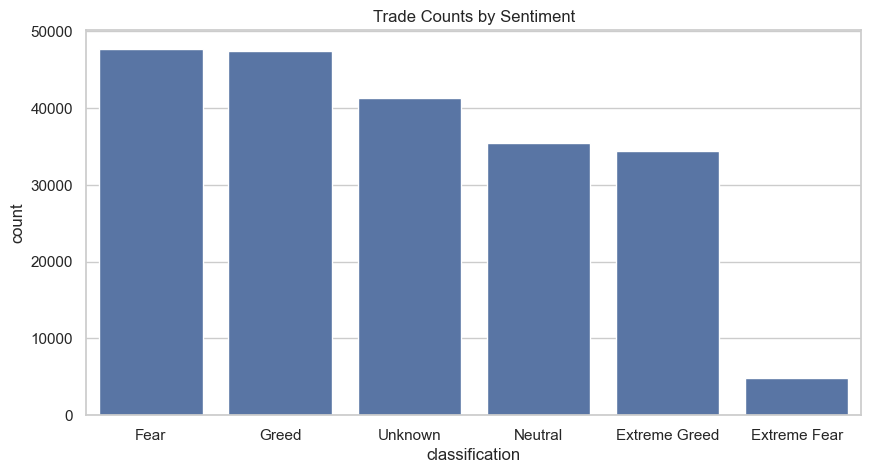

2025-10-23 14:25:32,480 INFO Saved ./ds_TUSHAR_SINGH/outputs\pnl_box_by_sentiment.png


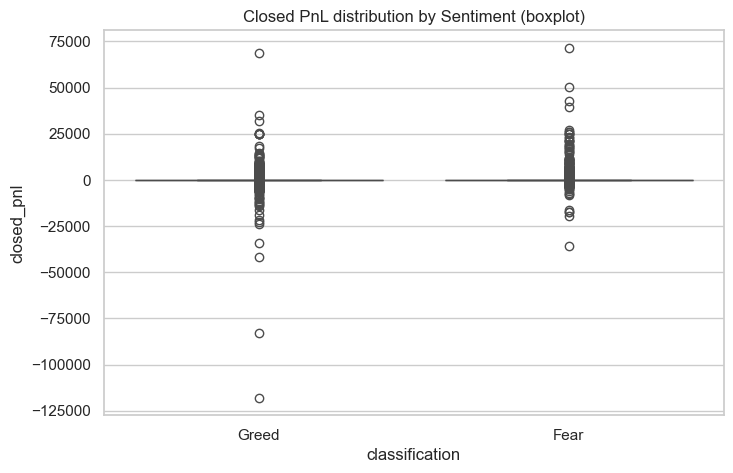

2025-10-23 14:25:32,700 INFO Saved ./ds_TUSHAR_SINGH/outputs\win_rate_by_sentiment.png


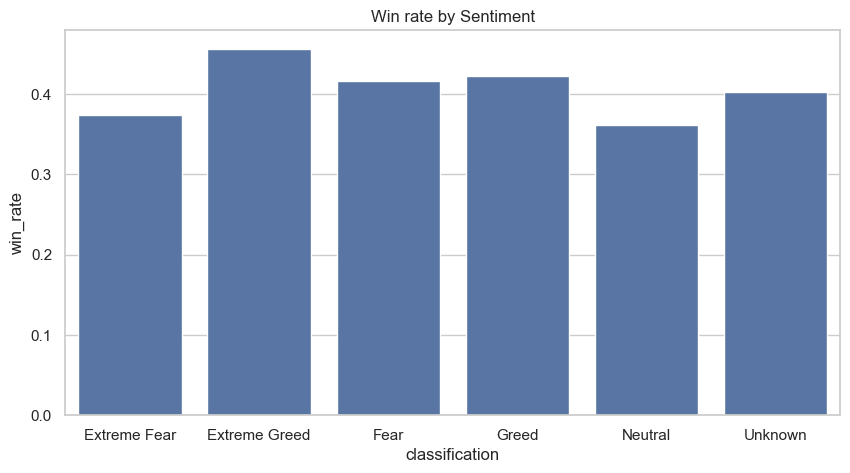

2025-10-23 14:25:33,220 INFO Saved ./ds_TUSHAR_SINGH/outputs\avg_daily_pnl_by_sentiment.png


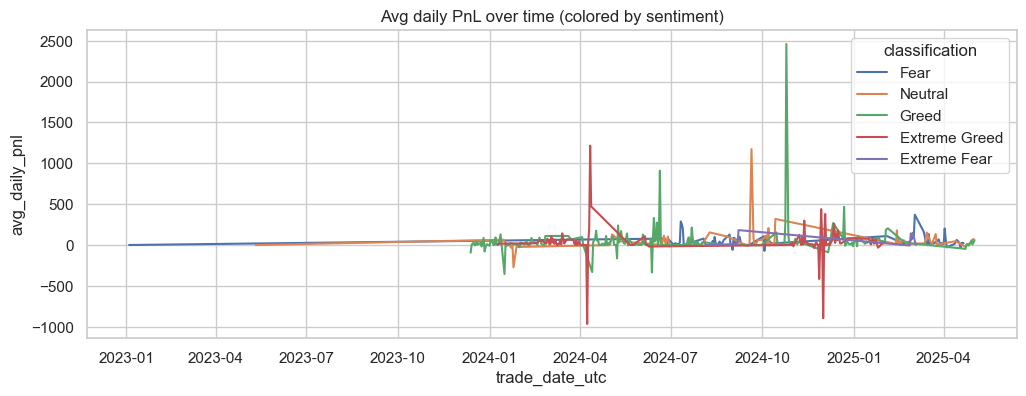

In [27]:
# Cell 12 - Save visuals to outputs
def savefig(fig, name):
    path = os.path.join(OUTPUTS_DIR, name)
    fig.savefig(path, dpi=150, bbox_inches='tight')
    logger.info("Saved %s", path)

# 1. Trade counts by sentiment
fig = plt.figure()
sns.countplot(data=m, x='classification', order=m['classification'].value_counts().index)
plt.title("Trade Counts by Sentiment")
savefig(fig, "trade_counts_by_sentiment.png")
plt.show()

# 2. PnL boxplot (Fear vs Greed)
fig = plt.figure(figsize=(8,5))
sns.boxplot(data=m[m['classification'].isin(['Fear','Greed'])], x='classification', y='closed_pnl')
plt.title("Closed PnL distribution by Sentiment (boxplot)")
savefig(fig, "pnl_box_by_sentiment.png")
plt.show()

# 3. Win rate bar
fig = plt.figure()
sns.barplot(data=summary, x='classification', y='win_rate')
plt.title("Win rate by Sentiment")
savefig(fig, "win_rate_by_sentiment.png")
plt.show()

# 4. Leverage vs PnL scatter (sample)
samp = m.dropna(subset=['leverage','closed_pnl']).sample(min(2000, len(m.dropna(subset=['leverage']))), random_state=1) if 'leverage' in m else pd.DataFrame()
if not samp.empty:
    fig = plt.figure()
    plt.scatter(samp['leverage'], samp['closed_pnl'], alpha=0.4)
    plt.xlabel("Leverage"); plt.ylabel("Closed PnL"); plt.title("Leverage vs Closed PnL (sample)")
    savefig(fig, "leverage_vs_pnl.png")
    plt.show()

# 5. Avg daily pnl time series colored by sentiment
daily = m.groupby('trade_date_utc').agg(avg_daily_pnl=('closed_pnl','mean')).reset_index()
daily = pd.merge(daily, fg_simple, left_on='trade_date_utc', right_on='fg_date', how='left')
fig = plt.figure(figsize=(12,4))
sns.lineplot(data=daily, x='trade_date_utc', y='avg_daily_pnl', hue='classification', legend='full')
plt.title("Avg daily PnL over time (colored by sentiment)")
savefig(fig, "avg_daily_pnl_by_sentiment.png")
plt.show()


In [28]:
# Cell 13 - T-test (Greed vs Fear)
from scipy import stats
g = m[m['classification']=='Greed']['closed_pnl'].dropna()
f = m[m['classification']=='Fear']['closed_pnl'].dropna()
logger.info("Samples - Greed: %d, Fear: %d", len(g), len(f))
if len(g)>10 and len(f)>10:
    tstat, pval = stats.ttest_ind(g, f, equal_var=False)
    print("t-stat:", tstat, "p-value:", pval)
else:
    print("Not enough samples for robust t-test. Greed n=", len(g), "Fear n=", len(f))


2025-10-23 14:25:40,448 INFO Samples - Greed: 47468, Fear: 47748


t-stat: -1.5868496355357031 p-value: 0.1125502095877912


In [29]:
# Cell 14 - Optional classifier (Greed vs Fear) - only if enough data
df_clf = m[m['classification'].isin(['Greed','Fear'])].copy()
df_clf['classification_bin'] = (df_clf['classification']=='Greed').astype(int)
features = ['closed_pnl','size_usd','size_tokens','leverage']
for fcol in features:
    if fcol not in df_clf: df_clf[fcol] = np.nan
df_clf = df_clf.dropna(subset=features + ['classification_bin'])
if len(df_clf) > 200:
    X = df_clf[features]
    y = df_clf['classification_bin']
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    scaler = StandardScaler().fit(X_train)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(scaler.transform(X_train), y_train)
    preds = clf.predict(scaler.transform(X_test))
    probs = clf.predict_proba(scaler.transform(X_test))[:,1]
    print(classification_report(y_test, preds))
    print("ROC AUC:", roc_auc_score(y_test, probs))
else:
    print("Not enough rows for classifier (need >200). Rows:", len(df_clf))


Not enough rows for classifier (need >200). Rows: 0


In [30]:
# Cell 15 - Create a report skeleton file (markdown) to convert to PDF manually
report_md = f"""
# Trader Behavior vs Market Sentiment — Candidate: {CANDIDATE_NAME}

## Objective
Analyze relationship between trader performance and daily Bitcoin market sentiment (Fear vs Greed).

## Data
- Historical trader data: {HISTORICAL_FILE_PATH}
- Fear/Greed index: {FEAR_GREED_PATH}

## Key Steps
1. Clean & normalize columns, parse Timestamp IST -> UTC.
2. Merge trades to daily sentiment by trade_date_utc.
3. Feature engineering: closed_pnl, win_rate, leverage, size, pnl_per_size.
4. Aggregation & visualizations.
5. Optional classifier/clustering.

## Deliverables (in repo)
- notebook_1.ipynb (this notebook)
- csv_files/processed_merged_trades_sentiment.csv
- csv_files/agg_by_sentiment.csv
- csv_files/account_level_summary.csv
- outputs/*.png (figures)
- ds_report.pdf (final 2-4 page summary — create from this markdown + recommended figures)

## Quick insights (fill after running)
- Fill in the top results and attach graphs saved in outputs/

"""
with open(os.path.join(ROOT_DIR, "report_skeleton.md"), "w") as f:
    f.write(report_md)

print("Report skeleton saved to", os.path.join(ROOT_DIR, "report_skeleton.md"))
print("All outputs saved to:", CSV_DIR, OUTPUTS_DIR)


Report skeleton saved to ./ds_TUSHAR_SINGH\report_skeleton.md
All outputs saved to: ./ds_TUSHAR_SINGH/csv_files ./ds_TUSHAR_SINGH/outputs
